### Dataset

As running example we use a dataset consisting of skin images, each labeled as belonging to classes: benign and malignant. We kept the number of images small so that this tutorial can be executed quickly; in practice at least 100 images per class should be provided.

### Storage Context
The storage context is used to determine where various output files such as augmented images or DNN model files will be stored (see the StorageContext documentation for more details). Normally, the storage content does not need to be set explicitely. However, when using the AML Workbench, to avoid its 25 MB limit on the project size, we are setting the cvtk outputs directory to point to a location outside the AML project (see in context.json: "../../../../cvtk_output"). Make sure to remove the "cvtk_output" directory once it is no longer needed.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import json, numpy as np, os, timeit 
from azureml.logging import get_azureml_logger
from imgaug import augmenters
from IPython.display import display
from sklearn import svm
from cvtk import ClassificationDataset, CNTKTLModel, Context, Splitter, StorageContext
from cvtk.augmentation import augment_dataset
from cvtk.core.classifier import ScikitClassifier
from cvtk.evaluation import ClassificationEvaluation, graph_roc_curve, graph_pr_curve, graph_confusion_matrix, basic_plot
import matplotlib.pyplot as plt
%matplotlib inline

# Disable printing of logging messages
from azuremltkbase.logging import ToolkitLogger
ToolkitLogger.getInstance().setEnabled(False)

# Set storage context.
out_root_path = "../../../cvtk_output"
Context.create(outputs_path=out_root_path, persistent_path=out_root_path, temp_path=out_root_path)

{
    "storage": {
        "outputs_path": "../../../cvtk_output",
        "persistent_path": "../../../cvtk_output",
        "temp_path": "../../../cvtk_output"
    }
}

### Step 1: Dataset Creation

The recommended way to generate a Dataset object in CVTK is by providing the root directory of the images on the local disk. This directory has to follow the same general structure as the tableware dataset, ie. contain sub-directories with the actual images:
- root
    - label1
    - label2
    - ...
    - labeln
  
Training an image classification model for a different dataset is therefore as easy as changing the root path `dataset_location` in the code below to point at different images.

In [2]:
# Root image directory 
dataset_location = "../../sample_data/isic_data"
dataset_name = 'isic'
dataset = ClassificationDataset.create_from_dir(dataset_name, dataset_location)
print("Dataset consists of {} images with {} labels.".format(len(dataset.images), len(dataset.labels)))
print("Select information for image 2: name={}, label={}, unique id={}.".format(
    dataset.images[2].name, dataset.images[2]._labels[0].name, dataset.images[2]._storage_id))

F1 2018-04-24 00:52:13,780 INFO azureml.vision:machine info {"is_dsvm": true, "os_type": "Windows"} 
F1 2018-04-24 00:52:13,786 INFO azureml.vision:dataset creating dataset for scenario=classification 
Dataset consists of 10 images with 2 labels.
Select information for image 2: name=ISIC_0000003.jpg, label=benign, unique id=116.


### Step 2: Image visualization and annotation

The widget below can be used to visualize the images in the dataset object, and to correct some of the labels if needed. In case you see a "Widget Javascript not detected" error, this can often be solved by running the command: 
  `jupyter nbextension enable --py --sys-prefix widgetsnbextension`

In [3]:
from ui_utils.ui_annotation import AnnotationUI
annotation_ui = AnnotationUI(dataset, Context.get_global_context())
display(annotation_ui.ui)

### Step 3: Image Augmentation

The augmentation module provides functionality to augment a dataset object using all the transformations described in the [imgaug](https://github.com/aleju/imgaug) library. Image transformations can be grouped in a single pipeline, in which case all transformations in the pipeline are applied simultaniously to each image. If you would like to apply different augmentation steps separately, or in any different manner, you can define multiple pipelines and pass them to the *augment_dataset* function. For more details and examples of image augmentation, see the [imgaug documentation](https://github.com/aleju/imgaug).

Adding augmented images to the training set is especially beneficial for small datasets. However, since it slows down DNN training due to the increased number of training images, our recommendation is to start experimentation without augmentation.

In [4]:
# Split the dataset into train and test  
train_set_orig, test_set = dataset.split(train_size = 0.66, stratify = "label")
print("Number of training images = {}, test images = {}.".format(train_set_orig.size(), test_set.size()))

F1 2018-04-24 00:52:14,214 INFO azureml.vision:splitter splitting a dataset 
F1 2018-04-24 00:52:14,220 INFO azureml.vision:dataset creating dataset for scenario=classification 
F1 2018-04-24 00:52:14,222 INFO azureml.vision:dataset creating dataset for scenario=classification 
Number of training images = 6, test images = 4.


In [5]:
augment_train_set = False

if augment_train_set:
    aug_sequence = augmenters.Sequential([
            augmenters.Fliplr(0.5),             # horizontally flip 50% of all images
            augmenters.Crop(percent=(0, 0.1)),  # crop images by 0-10% of their height/width
        ])
    train_set = augment_dataset(train_set_orig, [aug_sequence])
    print("Number of original training images = {}, with augmented images included = {}.".format(train_set_orig.size(), train_set.size()))
else:
    train_set = train_set_orig  

### Step 4: DNN Model Definition

Six different per-trained Deep Neural Network models are supported in CVTK: AlexNet, Resnet-18, Resnet-34, and Resnet-50, Resnet-101, and Resnet-152. These DNNs can be used either as classifier, or as featurizer (see step 5). More information about the networks can be found [here](https://github.com/Microsoft/CNTK/blob/master/PretrainedModels/Image.md), and a basic introduction to Transfer Learning is [here](https://blog.slavv.com/a-gentle-intro-to-transfer-learning-2c0b674375a0).

CVTK comes with default parametes (224x224 pixel resolution and Resnet-18 DNN) which were selected to work well on a wide variety of tasks. Accuracy can often be improved by eg. increasing the image resolution to 500x500 pixels, and/or selecting a deeper model (Resnet-50), however this comes at a significant increase in training time. See the "How to improve accuracy" section in the Appendix for more detail, and why the minibatch-size and the learning rate need to be updated.

In [6]:
# CVTK default parameters (224 x 224 pixels resolution, Resnet-18)
lr_per_mb = [0.05]*7 + [0.005]*7 +  [0.0005]
mb_size = 32
input_resoluton = 224
base_model_name = "ResNet18_ImageNet_CNTK"

# CVTK suggested parameters for 500 x 500 pixels resolution, Resnet-50
# (see in the Appendix "How to improve accuracy", last row in table)
# lr_per_mb   = [0.01] * 7 + [0.001] * 7 + [0.0001]
# mb_size    = 8
# input_resoluton = 500
# base_model_name = "ResNet50_ImageNet_CNTK"

# Initialize model
dnn_model = CNTKTLModel(train_set.labels,
                       base_model_name=base_model_name,
                       image_dims = (3, input_resoluton, input_resoluton))

### Step 5: Classifier Training

The pre-trained DNN from the last section can be used in two ways:
  - DNN refinement: This trains the DNN to directly perform the classification. While DNN training is slow, it typically leads to the best results since all network weights can be improved during training to give best accuracy.
  - DNN featurization: This runs the DNN as-is to obtain a lower-dimensional representation of an image (512, 2048, or 4096 floats), which is then used as input to train a separate classifier. Since the DNN is kept unchanged, this approach is much faster compared to DNN refinement, however accuracy is not as good. Nevertheless, training an external classifier such as a linear SVM (shown below) can provide a strong baseline, and help with understanding the feasibility of a problem.
  
Tensorboard can be used to visualize the training progress. To activate, add the parameter `tensorboard_logdir=PATH` as shown below, start the tensorboard client by running in a new console the command `tensorboard --logdir=PATH`, and open a web-browser as instructed by tensorboard (default is localhost:6006). 

In [7]:
# Train either the DNN or a SVM as classifier 
classifier_name = "dnn"

if classifier_name.lower() == "dnn":  
    dnn_model.train(train_set, lr_per_mb = lr_per_mb, mb_size = mb_size, eval_dataset=test_set) #, tensorboard_logdir=r"tensorboard"
    classifier = dnn_model
elif classifier_name.lower() == "svm":
    learner = svm.LinearSVC(C=1.0, class_weight='balanced', verbose=0)
    classifier = ScikitClassifier(dnn_model, learner = learner)
    classifier.train(train_set)
else:
    raise Exception("Classifier unknown: " + classifier)   

F1 2018-04-24 00:52:18,021 INFO azureml.vision:Fit starting in experiment  452118637 
F1 2018-04-24 00:52:18,022 INFO azureml.vision:model starting training for scenario=classification 
<class 'int'>
1 worker
Training transfer learning model for 15 epochs (epoch_size = 6).
non-distributed mode
Training 15740674 parameters in 53 parameter tensors.
Training 15740674 parameters in 53 parameter tensors.
Learning rate per minibatch: 0.05
Momentum per minibatch: 0.9
PROGRESS: 0.00%
Finished Epoch[1 of 15]: [Training] loss = 2.701239 * 6, metric = 83.33% * 6 2.362s (  2.5 samples/s);
Evaluation Set Error :: 33.33%
Finished Epoch[2 of 15]: [Training] loss = 1.254495 * 6, metric = 50.00% * 6 6.315s (  1.0 samples/s);
Evaluation Set Error :: 16.67%
Finished Epoch[3 of 15]: [Training] loss = 0.014524 * 6, metric = 0.00% * 6 0.087s ( 69.0 samples/s);
Evaluation Set Error :: 16.67%
Finished Epoch[4 of 15]: [Training] loss = 0.001979 * 6, metric = 0.00% * 6 0.100s ( 60.0 samples/s);
Evaluation Set E

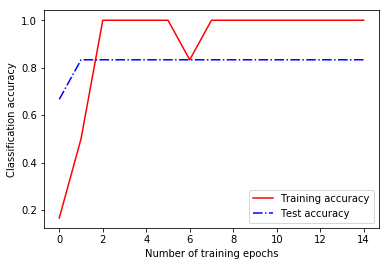

In [8]:
# Plot how the training and test accuracy increases during gradient descent. 
if classifier_name == "dnn":
    [train_accs, test_accs, epoch_numbers] = classifier.train_eval_accs
    plt.xlabel("Number of training epochs") 
    plt.ylabel("Classification accuracy") 
    train_plot = plt.plot(epoch_numbers, train_accs, 'r-', label = "Training accuracy")
    test_plot = plt.plot(epoch_numbers, test_accs, 'b-.', label = "Test accuracy")
    plt.legend()

In [16]:
# # Optional. Persist you model on disk and reuse it later for deployment. 
# from cvtk import TFFasterRCNN, Context
# import os
save_model_path = os.path.join(Context.get_global_context().storage.persistent_path, "saved_classifier.model")
# save_model_path = '../02_modeling/dnn.model'
# Save model to disk
dnn_model.serialize(save_model_path)

### Step 6: Evaluation and Visualization

The evaluation module provides functionality to evaluate the performance of the trained model on an independent test dataset. Some of the evaluation metrics it computes are: accuracy, precision and recall, confusion metrix, ROC curve, etc.

F1 2018-04-24 00:52:57,240 INFO azureml.vision:evaluation doing evaluation for scenario=classification 
F1 2018-04-24 00:52:57,242 INFO azureml.vision:model scoring dataset for scenario=classification 
Accuracy = 75.00%
Confusion matrix = 
[[3 0]
 [1 0]]


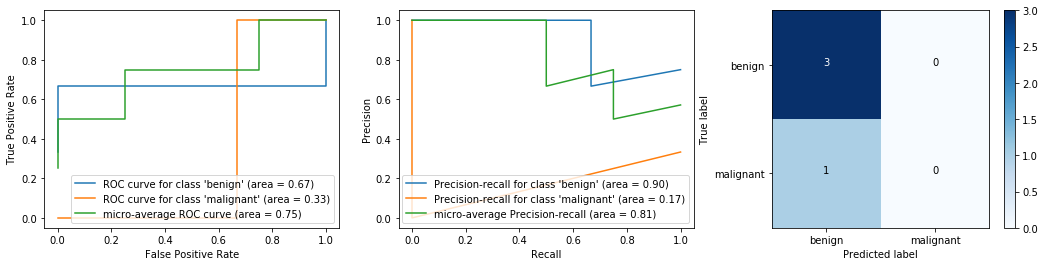

In [13]:
# Run the classifier on all test set images
ce = ClassificationEvaluation(classifier, test_set, minibatch_size = mb_size)

# Compute Accuracy and the confusion matrix
acc = ce.compute_accuracy()
print("Accuracy = {:2.2f}%".format(100*acc))
cm  = ce.compute_confusion_matrix()
print("Confusion matrix = \n{}".format(cm))

# Show PR curve, ROC curve, and confusion matrix
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3)
fig.set_size_inches(18, 4)
graph_roc_curve(ce, ax=ax1)
graph_pr_curve(ce, ax=ax2)
graph_confusion_matrix(ce, ax=ax3)
plt.show()

In [14]:
# Results viewer UI
labels = [l.name for l in dataset.labels] 
pred_scores = ce.scores #classification scores for all images and all classes
pred_labels = [labels[i] for i in np.argmax(pred_scores, axis=1)]

from ui_utils.ui_results_viewer import ResultsUI
results_ui = ResultsUI(test_set, Context.get_global_context(), pred_scores, pred_labels)
display(results_ui.ui)

In [15]:
# Precision / recall curve UI
precisions, recalls, thresholds = ce.compute_precision_recall_curve() 
thresholds = list(thresholds)
thresholds.append(thresholds[-1])
from ui_utils.ui_precision_recall import PrecisionRecallUI
pr_ui = PrecisionRecallUI(100*precisions[::-1], 100*recalls[::-1], thresholds[::-1])
display(pr_ui.ui) 


# APPENDIX 

# (A) Bing image download

The dataset object provides functionality to download images using the [Bing Image Search API](https://azure.microsoft.com/en-us/services/cognitive-services/bing-image-search-api/). Two types of search queries are supported: (i) regular text queries; and (ii) image URL queries. These queries need to be provided inside a json-encoded text file. In addition to the search queries, also their class label has to be specified (see this [sample json file](./misc/sample.json)). Furthermore, a Context object needs to be created explicitly and contain the Bing Image Search API key which requires a Bing Image Search API subscription. 



# (B) How to improve accuracy
The Computer Vision toolkit (CVTK) is shown to give good results for a wide variety of datasets. However, as is true for most machine learning projects, getting the best possible results for a new dataset requires careful parameter tuning, as well as evaluating different design decisions. The following sections provide guidance on how to improve accuracy on a given dataset, ie. what parameters are most promising to optimize first, what values for these parameters one should try, and what pitfalls to avoid.

Generally speaking, training Deep Learning models comes with a trade-off between training time versus model accuracy. The CVTK has pre-set default parameters (see 1st row in the table below) which focus on fast training speed while typically producing high accuracy models. This accuracy can often be improved further using e.g. higher image resolution or deeper models, however at the cost of increasing training time by a factor of 10x or more.

Our recommendation is to first work with the default parameters, train a model, inspect the results, correct ground truth annotations as needed, and only then try parameters which slow down training time (see table below suggested parameter values). An understanding of these parameters while technically not necessary is however recommended.


### Best-practice / Pitfalls / Tips:
* Data quality: the training and test sets should be of high quality. That is, the images are annotated correctly, ambiguous images removed (for example where it is unclear to a human eye if the image shows a tennis ball or a lemon), and the attributes are mutually exclusive (that is, each image belongs to exactly one attribute).
* Before refining the DNN, a SVM classifier should be trained using a pre-trained and fixed DNN as featurizer. This is supported in CVTK and does not require long to train since the DNN itself is not modified. Even this simple approach often achieves good accuracies and hence represents a strong baseline. The next step is then to refine the DNN which should give better accuracy.
* If the object-of-interest is small in the image then Image classification approaches are known to not work well. In such cases, consider using an object detection approach such as CVTK's Faster R-CNN based on Tensorflow.
* The more training data the better. As a rule-of-thumb, one should have at least 100 examples for each class, ie. 100 images for "dog", 100 images for "cat", etc. Training a model with less images is possible but might not produce good results.
* The training images need to reside locally on the machine with the GPU, and be on an SSD drive (not a HDD). Otherwise, latency from image reading can drastically reduce training speed (by even a factor of 100x).


### Parameters to optimize:
Finding optimal values for these parameters is important and can often improve accuracy significantly:
* Learning rate (`lr_per_mb`): The arguably most important parameter to get right. If the accuracy on the training set after DNN refinement is above ~5% then most likely the learning rate is either too high, or the number of training epochs too low. Especially with small datasets, the DNN tends to over-fit on the training data, however in practice this still leads to good models on the test set. We typically use 15 epochs where the inital learning rate is reduced twice; training using more epochs can in some cases improve performance.
* Input resolution (`image_dims`): The default image resolution is 224x224 pixels. Using higher image resolution of, for example, 500x500 pixels or 1000x1000 pixels can significantly improve accuracy but slows down DNN refinement. Note that CVTK expects the input resolution to be a tuple of (color-channels, image-width, image-height), e.g. (3, 224, 224), where the number of color channels has to be set to 3 (the Red-Green-Blue bands).
* Model architecture(`base_model_name`): Try using deeper DNNs such as ResNet-34 or ResNet-50 instead of the default ResNet-18 model. The Resnet-50 model is not only deeper, but its output of the penultimate layer is of size 2048 floats (vs. 512 floats of the ResNet-18 and ResNet-34 models). This increased dimensionality can be especially beneficial when keeping the DNN fixed and instead training an SVM classifier.
* Minibatch size (`mb_size`): High minibatch sizes will lead to faster training time however at the expense of an increased DNN memory consumption. Hence, when selecting deeper models (E.g. ResNet-50 versus ResNet-18) and/or higher image resolution (500\*500 pixels versus 224\*224 pixels), one typically has to reduce the minibatch size to avoid out-of-memory errors. When changing the minibatch size, often also the learning rate needs to be adjusted as can be seen in the table below.
* Drop-out rate (`dropout_rate`) and L2-regularizer (`l2_reg_weight`): DNN over-fitting can be reduced by using a dropout rate of 0.5 (default is 0.5 in CVTK) or more, and by increasing the regularizer weight (default is 0.0005 in CVTK). Note though that especially with small datasets DNN over-fitting is hard and often impossible to avoid.


### Parameter explanation:
- Learning rate: step size used during gradient descent learning. If set too low then the model will take many epochs to train, if set too high then the model will not converge to a good solution. Note that typically a schedule is used where the learning rate is reduced after a certain number of epochs. E.g. the learning rate schedule `[0.05]*7 + [0.005]*7 + [0.0005]` corresponds to using an initial learning rate of 0.05 for the first 7 epochs, followed by a 10x reduced learning rate of 0.005 for another 7 epochs, and finally fine-tuning the model for a single epoch with a 100x reduced learning rate of 0.0005.
- Minibatch size: GPU's can process multiple images in parallel to speed up computation. These parallel processed images are also referred as a minibatch. The higher the minibatch size the faster training will be, however at the expense of a significantly increased DNN memory consumption.

### Suggested parameters values:
The table below provides different parameter sets which were shown to produce high accuracy models on a wide variety of image classification tasks. The optimal parameters depend on the specific dataset and on the exact GPU used, hence the table should be seen as a guideline only. After trying these parameters, consider also image resolutions of more than 500x500 pixels, or deeper models such as Resnet-101 or Resnet-152.

The first row in the table corresponds to the default parameters which are set inside CVTK. All other rows take longer to train (indicated in the first column) however at the benefit of increased accuracy (see the second column for the average accuracy over three internal datasets). For example, the parameters in the last row take 5-15x longer to train, however resulted in significantly increased (averaged) accuracy on three internal test sets from 82.6% to 92.8%.

Deeper models and higher input resolution take up more DNN memory, and hence the minibatch size needs to be reduced with increased model complexity to avoid out-of-memory-errors. As can be seen in the table below, we found it beneficial to decrease the learning rate by a factor of two whenever decreasing the minibatch size by the same multiplier. Note that the minibatch size might need to get reduced further on GPUs with smaller amounts of memory.

| Training time (rough estimate) | Example accuracy | Minibatch size (`mb_size`) | Learning rate (`lr_per_mb`) | Image resolution (`image_dims`) | DNN architecture (`base_model_name`) |
|------------- |:-------------:|:-------------:|:-----:|:-----:|:---:|
| 1x (reference) | 82.6% | 32 | [0.05]\*7  + [0.005]\*7  + [0.0005]  | (3, 224, 224) | ResNet18_ImageNet_CNTK |
| 2-5x    | 90.2% | 16 | [0.025]\*7 + [0.0025]\*7 + [0.00025] | (3, 500, 500) | ResNet18_ImageNet_CNTK |
| 2-5x    | 87.5% | 16 | [0.025]\*7 + [0.0025]\*7 + [0.00025] | (3, 224, 224) | ResNet50_ImageNet_CNTK |
| 5-15x        | 92.8% |  8 | [0.01]\*7  + [0.001]\*7  + [0.0001]  | (3, 500, 500) | ResNet50_ImageNet_CNTK |
